In [1]:
from adaptivecover_kmapper.adaptivecover_kmapper import KMapperAdaptiveCover
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
# from sklearn_pyclustering_shim.xmeans import PyclusteringXMeans
# from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from mapper_xmean_cover import Cover
import kmapper as km
import numpy as np
from scipy.special import gamma, gammaln
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from statistics import mode
import matplotlib.pyplot as plt
import sys, os
import collections
from datetime import datetime
import sklearn
import networkx as nx
import math
import json

data_path = "../tda_chicago_general/data/"
mapper_instance = km.KeplerMapper()

In [2]:
def mean_nth_neighbor_unbounded(dim, n_neighbor, n_samples):
    t1 = (gamma(dim/2 + 1)**(1/dim))/math.sqrt(np.pi)
    t2 = np.exp(gammaln(n_neighbor+1/dim) - gammaln(n_neighbor))
    t3 = np.exp(gammaln(n_samples) - gammaln(n_samples + 1/dim))
    return t1*t2*t3

In [3]:
def mean_nth_neighbor_sample(sample):
    dist = squareform(pdist(sample))
    dist.sort(axis=1)
    return dist.mean(axis=0)

In [4]:
def mapper_pipeline(data, dist_threshold=0.1):
    input_data = data
    input_data_proj = mapper_instance.project(input_data, projection = [-1], scaler = None)
    input_col_names = []

    cubes = 40   # number of intervals
    overlap = 0.6 # how much they overlap
    distance_threshold = dist_threshold
    clusterer = AgglomerativeClustering(n_clusters=None, linkage="centroid", distance_threshold=distance_threshold)

    initial_cover = Cover(num_intervals=cubes,percent_overlap=overlap)
    cover = KMapperAdaptiveCover(input_data,input_data_proj,initial_cover=initial_cover,clusterer=clusterer)

    fname_suffix = f"sphere_{dist_threshold}"
    html_path =  f"outputs/noise_{fname_suffix}.html"
    json_path  = f"outputs/noise_{fname_suffix}.json"
    title = "Noise Test"

    output_graph = mapper_instance.map(input_data_proj, input_data, clusterer=clusterer, cover=cover)

    mapper_instance.visualize(output_graph, 
        path_html = html_path,
        title=title, 
        color_values=input_data[:,-1],
        color_function_name = "filter")


    km.adapter.to_json(
        output_graph,
        input_data_proj,
        input_data,
        input_col_names,
        data_path,
        json_path,
    )

    return output_graph

In [5]:
rng = np.random.default_rng()
# noise = rng.uniform(size=(2000,2))

# for d in np.arange(0.05, 0.95, 0.05):
#     twoDgraph = mapper_pipeline(noise, d)

In [6]:
# (1/2)*(noise[[11,246,537,574,1009,1067,1302,1339,1590]][:,0].max()-noise[[11,246,537,574,1009,1067,1302,1339,1590]][:,0].min())

In [7]:
# noise = rng.uniform(size=(2000,3))
# for d in np.arange(0.05, 0.95, 0.05):
#     threeDgraph = mapper_pipeline(noise, d)

In [8]:
# noise = rng.uniform(size=(2000,4))

# for d in np.arange(0.05, 0.95, 0.05):
#     fourDgraph = mapper_pipeline(noise, d)

In [9]:
def generate_degree_histogram(G: nx.Graph, title="", figwidth=15):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True) 

    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(f"{title} Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg, rotation=-80)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    fig.set_figwidth(figwidth)
    plt.axis('off')
    plt.show()
    
    plt.close()

In [10]:
# nx.average_node_connectivity(km.adapter.to_nx(fourDgraph))

In [11]:
mean_nth_neighbor_unbounded(3, 20, 2000)

0.13291542018273836

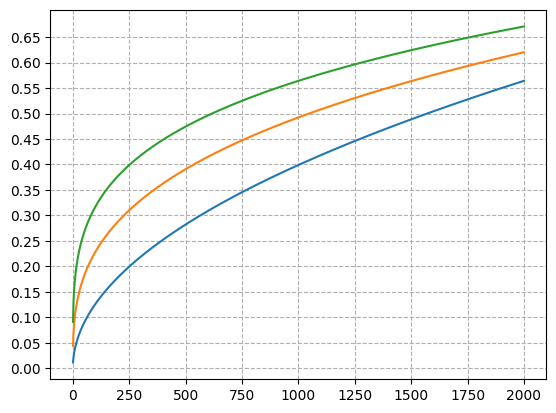

In [12]:
p = (math.log(1+ math.sqrt(2))+math.sqrt(2))
x = np.linspace(1,2000, 2000)
vmean_nth_neighbor = np.vectorize(mean_nth_neighbor_unbounded, excluded=["dim","n_samples"])
y2 = vmean_nth_neighbor(2, x, 2000)
y3 = vmean_nth_neighbor(3, x, 2000)
y4 = vmean_nth_neighbor(4, x, 2000)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)
plt.yticks(np.arange(0.0,0.7,0.05))
plt.grid(linestyle="--")
plt.show()
plt.close()

[0.00144684 0.00015709 0.00055373]


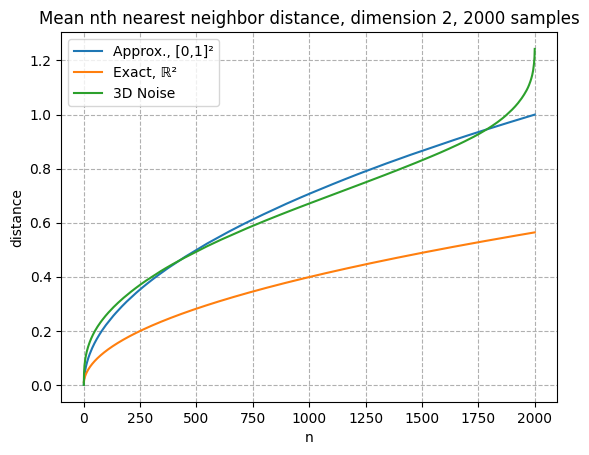

In [18]:
noise = rng.uniform(size=(2000,3))
dist = squareform(pdist(noise))
dist.sort(axis=1)
noise_mean = dist.mean(axis=0)

N=2000
pts=rng.standard_normal(size=[N,3])          #get 3 N-length values
pts/=np.sqrt(np.sum(pts**2,axis=-1)[:,np.newaxis])   #normalize: v=v/|v|
pts*= 1/2
pts+= np.full((2000,3), 1/2)
print(pts.min(axis=0))
mean = mean_nth_neighbor_sample(pts)
plt.plot(x, mean, '-', label="Approx., [0,1]²")
plt.plot(x, y2,'-', label="Exact, ℝ²")
plt.plot(x, noise_mean, label="3D Noise")
plt.grid(linestyle="--")
# plt.axis([0,50,0,0.25])
plt.ylabel("distance")
plt.xlabel("n")
plt.title("Mean nth nearest neighbor distance, dimension 2, 2000 samples")
plt.legend()
plt.savefig("mean_nth_nn_2d_2000_samples_comparison.png")

In [20]:
g = mapper_pipeline(pts,0.1576960267356499)

Deleted 0 intervals


In [15]:
mean_nth_neighbor_unbounded(3, 50, 2000)

0.1809985536471576

In [21]:
json.dump(nx.node_link_data(km.adapter.to_networkx(g)), open('test.json','w+'))

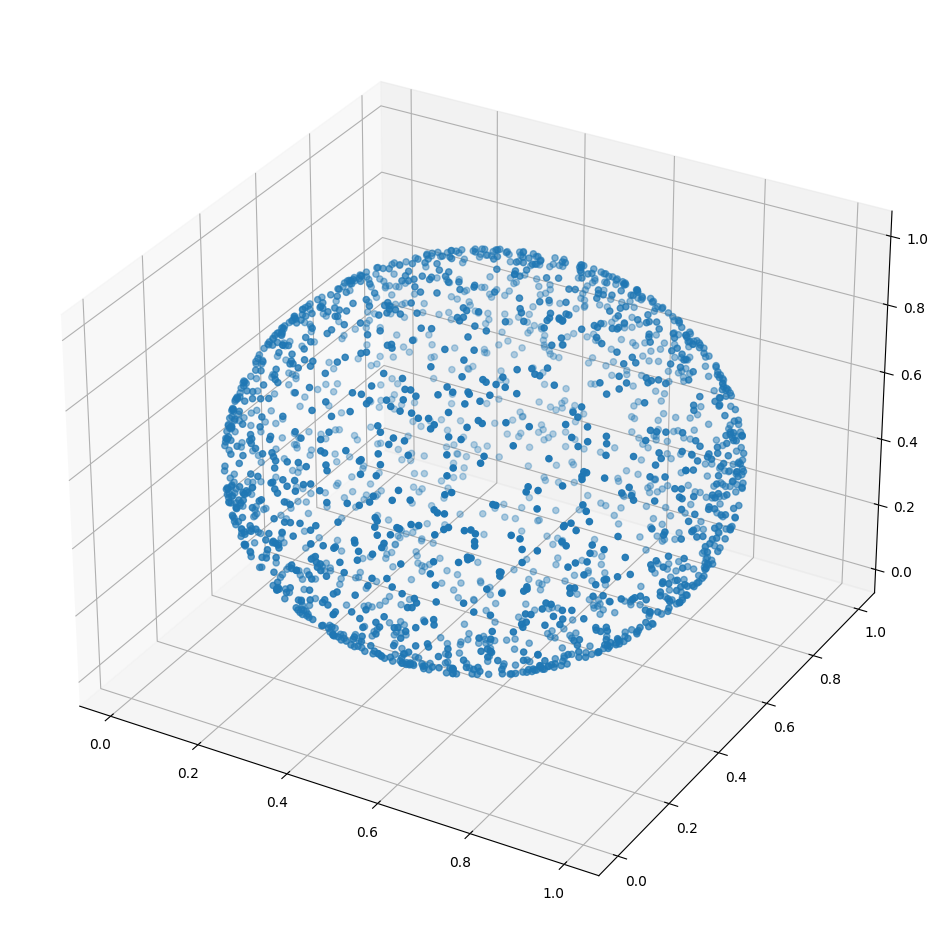

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[:,0],pts[:,1],pts[:,2])
plt.show()